使用lenses.txt 中的隐形眼镜数据集，采用第三章中介绍的ID3 算法构建决策树。使用决策树，输入几组隐形眼镜特征数据，例如：'young','hyper','no','reduced'，'pre','hyper','no','normal'；等进行测试，预测隐形眼镜类型。

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'young': 'hard', 'pre': 'no lenses', 'presbyopic': 'no lenses'}}}}, 'no': {'age': {'young': 'soft', 'pre': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}}}}, 'reduced': 'no lenses'}}


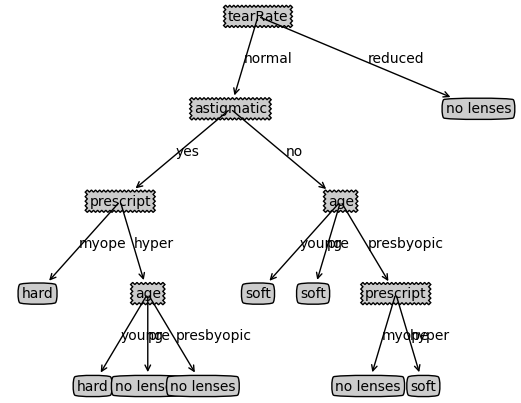

In [20]:
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier


def calcShannonEnt(dataset):
    numEntries=len(dataset)
    labelCounts={}
    for featVec in dataset:
        currentLabel=featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    shannonEnt=0.0
    for key in labelCounts:
        prob=float(labelCounts[key])/numEntries
        shannonEnt-=prob*math.log(prob,2)
    return shannonEnt

def splitDataSet(dataset, axis, value):
    retDataSet=[]
    for featVec in dataset:
        if featVec[axis]==value:
            reducedFeatVec=featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def chooseBestFeature(dataset):
    numFeatures=len(dataset[0])-1
    baseEntropy=calcShannonEnt(dataset)
    bestInfoGain=0.0
    bestFeature=-1
    for i in range(numFeatures):
        featList=[example[i] for example in dataset]
        uniqueVals=set(featList)
        newEntropy=0.0
        for value in uniqueVals:
            subDataset=splitDataSet(dataset,i,value)
            prob=len(subDataset)/float(len(dataset))
            newEntropy+=prob*calcShannonEnt(subDataset)
        infogain=baseEntropy-newEntropy
        if(infogain>bestInfoGain):
            bestInfoGain=infogain
            bestFeature=i
    return bestFeature

def majorityCnt(typeList):
    classCount={}
    for vote in typeList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount=sorted(classCount.iteritems(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

def id3(dataset,labels):
    typeList=[example[-1] for example in dataset]
    if typeList.count(typeList[0])==len(typeList):
        return typeList[0]
    if len(dataset[0])==1:
        return majorityCnt(typeList)
    bestFeat=chooseBestFeature(dataset)
    bestFeatLabel=labels[bestFeat]
    decisionTree={bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues=[example[bestFeat] for example in dataset]
    uniqueVals=set(featValues)
    for value in uniqueVals:
        subLabels=labels[:]
        decisionTree[bestFeatLabel][value]=id3(splitDataSet(dataset,bestFeat,value),subLabels)
    return decisionTree

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction', va="center",ha="center",bbox=nodeType,arrowprops=arrow_args)

# def createPlot():
#     fig=plt.figure(1,facecolor='white')
#     plt.clf()
#     createPlot.ax1=plt.subplot(111,frameon=False)
#     plotNode('决策节点',(0.5,0.1),(0.1,0.5),decisionNode)
#     plotNode('叶节点',(0.8,0.1),(0.3,0.8),leafNode)
#     plt.show()

def getNumLeafs(tree):
    numLeafs=0
    firstStr=list(tree.keys())[0]
    secondDict=tree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else:
            numLeafs+=1
    return numLeafs

def getTreeDepth(tree):
    maxDepth=0
    firstStrr=list(tree.keys())[0]
    secondDict=tree[firstStrr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else:
            thisDepth=1
        if thisDepth>maxDepth:
            maxDepth=thisDepth
    return maxDepth

def plotMidText(cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2.0+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2.0+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)

def plotTree(tree,parentPt, nodeTxt):
    numLeafs=getNumLeafs(tree)
    depth=getTreeDepth(tree)
    firstStr=list(tree.keys())[0]
    cntrPt=(plotTree.x0ff+(1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.y0ff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=tree[firstStr]
    plotTree.y0ff=plotTree.y0ff-1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.x0ff=plotTree.x0ff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.x0ff,plotTree.y0ff),cntrPt,leafNode)
            plotMidText((plotTree.x0ff,plotTree.y0ff),cntrPt,str(key))
    plotTree.y0ff=plotTree.y0ff+1.0/plotTree.totalD

def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.x0ff=-0.5/plotTree.totalW
    plotTree.y0ff=1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

data=pd.read_csv("C:/Users/Admin/Desktop/WHU study/programming/python/MachineLearning/exp2/lenses.txt",sep='\t', header=None)
data.head()# line1 age line2 prescript line3 astigmatic lie4 tearrate line5 lensetype

# print(data[0,1,2,3].values.tolist())
# print(data[4].tolist())

datainput=data.values.tolist()
labels=['age','prescript','astigmatic','tearRate']
# print(datainput)
# print(labels)
decisiontree=id3(datainput,labels)
print(decisiontree)
createPlot(decisiontree)
# dataset=[[1,1,'yes'],[1,1,'yes'],[1,0,'no'],[0,1,'no'],[0,1,'no']]
# labels=['no surfacing','flippers']
# 
# print(calcShannonEnt(dataset))

# decisionNode=dict(boxstyle="sawtooth",fc="0.8")
# leafNode=dict(boxstyle="round4",fc="0.8")
# arrow_args=dict(arrowstyle="<-")


2 利用机器学习库sklearn中的决策树分类器DecisionTreeClassifier对
Iris 数据集进行交叉验证，测试其准确率。

3.利用机器学习库sklearn中的随机森林分类器RandomForestClassifier
对Iris 数据集进行交叉验证，测试其准确率。

0.9333333333333333
0.9


[Text(0.3333333333333333, 0.9, 'x[3] <= 0.7\ngini = 0.66\nsamples = 80\nvalue = [33, 47, 40]'),
 Text(0.16666666666666666, 0.7, 'gini = 0.0\nsamples = 25\nvalue = [33, 0, 0]'),
 Text(0.5, 0.7, 'x[2] <= 4.85\ngini = 0.497\nsamples = 55\nvalue = [0, 47, 40]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 27\nvalue = [0, 44, 0]'),
 Text(0.6666666666666666, 0.5, 'x[3] <= 1.75\ngini = 0.13\nsamples = 28\nvalue = [0, 3, 40]'),
 Text(0.5, 0.3, 'x[0] <= 7.05\ngini = 0.375\nsamples = 3\nvalue = [0, 3, 1]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 3, 0]'),
 Text(0.6666666666666666, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.8333333333333334, 0.3, 'gini = 0.0\nsamples = 25\nvalue = [0, 0, 39]')]

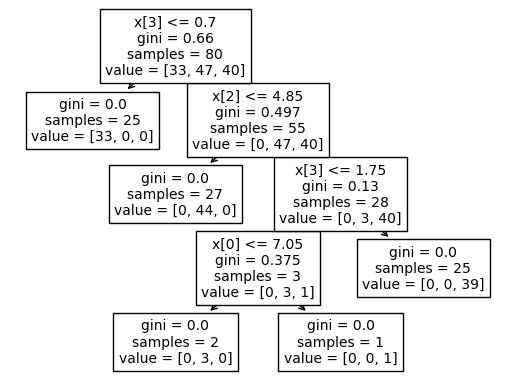

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

iris=datasets.load_iris()
X=iris.data
Y=iris.target

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

clf=DecisionTreeClassifier()
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))

rfc=RandomForestClassifier(n_estimators=10)
rfc.fit(X_train,Y_train)
print(rfc.score(X_test,Y_test))

tree.plot_tree(clf)
tree.plot_tree(rfc.estimators_[0])